In [ ]:
%%capture
!pip install transformers bertviz sentence_transformers dask[bag] emoji gradio

In [ ]:
#@markdown Run this cell to mount the data drive.
from google.colab import drive
import os
drive.mount('/content/drive')

directory = '/content/drive/MyDrive/DLE-Projects' #@param {type:"string"}
#@markdown Hint: In case of errors, try Runtime -> Factory reset runtime and rerun from the top.
%matplotlib inline
%cd /content/drive/MyDrive/Colab\ Notebooks

import sys
sys.path.insert(0, os.path.join(directory, 'utils'))

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
#@title Importing packages
from sentence_transformers import SentenceTransformer
import transformers
from bertviz import model_view, head_view
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel
from assignment_helpers import *


import numpy as np
import os
import pandas as pd
import torch
import imageio
import emoji
import gradio as gr
import transformers
from sklearn.manifold import TSNE

import torch.nn.functional as F

import torch.nn as nn
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

from assignment_helpers import *


# Welcome to Week 4!

In this final week, we will be getting hands-on practice with using Transformers and Large Language Models (LLMs).

By the end of the assignment, we hope that you will gain a familiarity with how Transformers work and how you can use LLMs for downstream data science tasks!

## Overview of Week 4

1. Transformers
2. Applying LLMs to downstream tasks


# 1. Transformers

Transformers are a powerful type of neural network that have broad applicability to a wide variety of domains across NLP, biological data, and images.

In general, understanding Transformers is hard since there are so many layers and modules. For a deeper dive, please visit the course content, where we cover what each module does. However, in this notebook, we wanted to give a tutorial of how a few key concepts work.

## Breaking down a Transformer

<img src='https://drive.google.com/uc?id=1MsVl_9qH4S1wPIrMNxtioUePKLPt0KsQ' width="400">

In this project, we will cover three key concepetual components:

1. Tokenization and Input Embeddings
2. Self-Attention
3. Model Embeddings

These three parts constitute what we put *into* a network, the *magic sauce* of the network, and how to *use the outputs* of the network.

## Section 1: Input Embeddings

Input embeddings are arrays of numbers that represent the input data.

The most common input data you'll see used for Transformers are text.

This is a little side detour into NLP, but it's important for understand the very first step into our Transformer model.

First, let's start with a sentence: "Coffee tastes best in the morning."

How do we represent this as an array of numbers? We use a vocabulary, which is just a giant dictionary of words. Each word has a unique ID. The word 'apple' could be 6207, and the word 'steam' could be 5492. As such, a whole sentence will just be an array of indices. This is *almost* how Transformers take their inputs, except that they pass this array through a fully connected layer before feeding it into their network.

But first, in the example below, you'll see how one a vocabulary works. We will be using the "bert-base-uncased" tokenizer. A *tokenizer* converts sentences (strings) into tokens (also strings, but separated by spaces and other characters).

In [ ]:
# Just run this cell!

# Instantiate a tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define our input string
input_string = "Coffee tastes best in the morning."

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In this cell below, tokenize ```input_string``` using the function ```.tokenize()```. Then, use the function ```.convert_tokens_to_ids()``` to turn the tokens into a list of the indices they correspond to in the vocabulary.

In [ ]:
# TODO: Tokenize input_string
tokens = tokenizer.tokenize(input_string)

# TODO: Get the corresponding IDs for each token
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# TODO: Print token_ids
print(f"Token Ids: {token_ids}")

Token Ids: [4157, 16958, 2190, 1999, 1996, 2851, 1012]


In [ ]:
#@title Run this cell to check your answer!

check_answer(token_ids == [4157, 16958, 2190, 1999, 1996, 2851, 1012])

## Correct! 🎉

The vocabulary itself is accessible through ```tokenizer.get_vocab()```. For intuition building purposes, verify to yourself that these ```token_ids``` actually correspond to the words you want by looking up a couple words from the sentence and matching it with its position in ```token_ids```.

In [ ]:
# TODO: Get vocab
vocab = tokenizer.get_vocab()

# Find the id for 'coffee'
coffee_id = vocab['coffee']
print(coffee_id)

# Print the size of the vocabulary
vocab_size = len(vocab)
print(vocab_size)



4157
30522


In [ ]:
#@title Run this cell to check your answer!

check_answer(coffee_id == 4157 and vocab_size == 30522)

## Correct! 🎉

What happens if a word is not in the vocabulary?

Try tokenizing a non-sense word and see what the output is!

In [ ]:
# TODO: Run this cell with your own string
tokenizer.tokenize('Manchester United is my favorite football club')

['manchester', 'united', 'is', 'my', 'favorite', 'football', 'club']

The tokenizer chunks words into known components, so a word can actually be represented as multiple tokens!

Different tokenizers also tokenize words differently.

Let's load another tokenizer (in the cell below).

In [ ]:
# Run this cell
biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

How does the word 'pneumothorax' get tokenized differently in the BioBert tokenizer vs. the regular Bert tokenizer?

In [ ]:
print(tokenizer.tokenize('pneumothorax'))

print(biobert_tokenizer.tokenize('pneumothorax'))

['p', '##ne', '##um', '##otho', '##ra', '##x']
['p', '##ne', '##um', '##oth', '##orax']


Great! Hopefully you are more familarized with how tokenizers work now.

Next, let's turn our attention to input embeddings.

Before we can feed our sentence into a transformer, we need to pre-process it. This involves turning each token into an embedding, such that similar words have similar embeddings. To do so, we use an ```nn.Linear``` layer to pass in the tokens. Essentially, the linear layer maps the one-hot encoded token vectors into a higher dimensional space.

In the cell below, first take ```token_ids``` and convert it to a matrix of dimension (num_tokens_in_input_string, vocab_size), where each row is a token in ```input_string```, represented as 0's everywhere except for its index in the vocab, where it will have a 1. Hint: You can use the ```F.one_hot()``` function!

Next, feed it through an ```nn.Linear``` layer with vocab_size input nodes and 16 output nodes.

In [ ]:
# TODO: Turn token_ids into a one-hot encoded matrix as described above.
token_ids_tensor = torch.tensor(token_ids)
one_hot_encoding = F.one_hot(token_ids_tensor, num_classes=len(vocab))

# TODO: Create the Linear layer
embedding_layer = nn.Linear(vocab_size, 16, bias=True)

# TODO: Get outputs of the Linear layer
input_embedding = embedding_layer(one_hot_encoding.float())

In [ ]:
#@title Run this cell to check your answer!

check_answer(input_embedding.size() == torch.Size([7, 16]))

## Correct! 🎉

Great! If you did this correctly, you should end up with a tensor of size (length_of_token_ids, 16).

Note that when you have multiple sentences to process at a time, you would pad shorter sentences with 0 in order to make them all the same length.

One final detail is that PyTorch has a layer specifically designed for the purpose of turning ```token_ids``` into ```input_embedding```! It's called ```nn.Embedding```. They are the same thing, but the only difference is that ```nn.Embedding``` saves computation by just accepting the indices of tokens as input, rather than requring you to create a one-hot encoding of each token. The input to ```nn.Embedding``` is an array of indices, one for each token in the sentence.

(Note: ```nn.Embedding``` takes ```torch.LongTensor``` as input!)

In the cell below, implement the embedding layer and verify that the resulting size is the same.

In [ ]:
# TODO: Create an nn.Embedding layer with embedding_dim=16
embedding_layer = nn.Embedding(vocab_size, 16)

# TODO: Get the embeddings for input_string
input_embedding = embedding_layer(torch.LongTensor(token_ids))

# TODO: Print the dimensions of intput_embed
print(input_embedding.shape)

torch.Size([7, 16])


In [ ]:
#@title Run this cell to check your answer!

check_answer(input_embedding.size() == torch.Size([7, 16]))

## Correct! 🎉

For now, ```input_embed``` is a rather meaningless embedding, but the embedding layer itself is a *learnable* parameter, so as the model trains, it will optimize how it represents the data!

Note the dimensions of ```input_embed```: Each word is represented as a vector of length ```embedding_dim```, and our input to the model is a sequence of such vectors.

## Section 2: Attention, Please!

The key to the success of Transformers lies in the idea of *attention*.

In technical terms, the *attention* we pay to a specific word in a sentence (or a value in a sequence) is a number we multiply it by. The greater the number, the more attention is applied to it. For example, if we only wanted to pay attention to the words "coffee" and "morning" in the sentence above, we would multiply the sentence by a vector like ```[1, 0, 0, 0, 0, 1, 0]```. The product would be something like ```["coffee", "morning"]```. Now imagine instead of just 1s and 0s, we modulate it using numbers between 1 and 0, so that we pay varying levels of attention to each word. That's the central idea behind attention.

In the cell below, we are going to visualize attention in a pre-trained LLM. We will be using a module called ```AutoModel``` to load the BERT model.  (More information found [here](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html)). This is a wrapper class that allows you to easily load pre-trained models using just the name of the model. In the cell below, we'll load a BERT model called "bert-base-uncased", which stands for a "Bidirectional Encoder Representations from Transformers". The "base" refers to this being a base model (not used in any fine-tuned task yet), and "uncased" refers to the fact that it does not distinguish words based on capitalization. More information can be found here: [BERT](https://huggingface.co/bert-base-uncased?text=The+goal+of+life+is+%5BMASK%5D.)

First, you need to get the model's output from ```input_text```.
This will require tokenizing it, and feeding in the token_ids.
To retrieve attentions, you will need to access the last element of the model outputs.

In [ ]:
# Run this cell, and then work on code in the following cell.
input_text = "Of all the unusual things about Harry, this scar was the most extraordinary of all."

# Creating a BERT model, which has output_attentions=True
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# TODO: Tokenize input_text using tokenizer.encode()
inputs = tokenizer.encode(input_text, return_tensors='pt')

# TODO: Get model outputs
outputs = model(inputs)

# TODO: Get model attentions
attention = outputs[-1]

# Get the tokens we used in the tokenizer (Done for you)
tokens = tokenizer.convert_ids_to_tokens(inputs[0])

In [ ]:
#@title Run this cell to check your answer!
check_answer(len(attention) == 12 and attention[0].size() == torch.Size([1, 12, 19, 19]))

## Correct! 🎉

Great! Now we're all set to visualize how the Bert model does self-attention.

We'll be using a helpful library called BertViz.

The first cell will produce a chart of all the attentions by the model. Click on each rectangle to see how that attention head sees the sentence. Notice anything interesting? You should see that many attentions are redundant!

In [ ]:
# Run this cell
model_view(attention, tokens)

Output hidden; open in https://colab.research.google.com to view.

The second cell produces the view from each head. Feel free to click through each layer and see how they attend to each word differently.

In [ ]:
head_view(attention, tokens)

Output hidden; open in https://colab.research.google.com to view.

If you think these attentions are hard to interpret, you're not alone! In general, this is a drawback of large models. Even as self-attention might be an intuitive concept, the reality is that they are implemented by the network in ways that humans don't have deep understandings of.

It's more helpful to think of these attention modules working together, rather than having individual meanings.

## Section 3: Model Embeddings

The last thing we'll cover is how to use these networks to extract embeddings from sentences.

This is particularly useful if you just have some free text which you want to turn into concrete features.

So for example, you could have a set of user reviews like:

'I loved working with Robin, he made my job as Batman much easier'

'I didn't care too much for the Joker's laugh'

One thing you could do here is to turn each sentence into a fixed-length vector, representing the sentence's meaning!

In the cell below, we will use ```SentenceTransformer```, which makes encoding whole sentences easy.



In [ ]:
# Run this cell

model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
sentences = ["I loved working with Robin, he made my job as Batman much easier",
             "I didn't care too much for the Joker's laugh"]
embeddings = model.encode(sentences)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

The embeddings of this particular model, ```paraphrase-MiniLM-L6-v2```, has an embedding size of 384. Run the cell below to verify the size of the embedding array of two sentences.

In [ ]:
# Run this cell
print(embeddings.shape)

(2, 384)


The output, ```embeddings``` is a list which contains an embedding for each sentence.

Let's try this out on a real dataset!

In the cells below, we'll be using a dataset of tweets about airlines.

Let's get a quick look at what this dataset looks like. Run the cells below:


In [ ]:
# Just run this cell!
df_airline = pd.read_csv(os.path.join(directory, 'utils/data', 'airline_data.csv'), nrows=1000)
df_airline.head()

,airline,text
0,United,"@united 877 from amsterdam to ewr, 02.27.2015,..."
1,Southwest,@SouthwestAir I'm on the 10:55 flight! Everyon...
2,American,@AmericanAir we have posted your response on f...
3,US Airways,@USAirways a big thanks to the gate agent flt5...
4,Southwest,@SouthwestAir Do y'all know when the new route...


In [ ]:
# Just run this cell!

for i in range(10):
  print(df_airline['text'].iloc[i])
  print('-'*50)

@united 877 from amsterdam to ewr, 02.27.2015, 737-300.
--------------------------------------------------
@SouthwestAir I'm on the 10:55 flight! Everyone has been so nice and helpful! I'm just hoping we'll get to fly out! Thank you! ;)
--------------------------------------------------
@AmericanAir we have posted your response on facebook for everyone to see people are appalled by your lack of concern
--------------------------------------------------
@USAirways a big thanks to the gate agent flt5127..keeping us informed of the delay#greatcustomerservice
--------------------------------------------------
@SouthwestAir Do y'all know when the new routes from HOU to Aruba &amp; Puerto Vallarta will be available?
--------------------------------------------------
@USAirways 502 M-phx Im still on The plane waiting And waiting
--------------------------------------------------
@USAirways I bougth ticket same fligths twice and you dont refund money it is big problem other company refund mone

This dataset (stored as a Pandas dataframe) is a collection of tweets about major U.S. airlines, scraped from Feburary 2015. You'll see three columns: ```airline``` and ```text```. (More details here: [data.world](https://data.world/crowdflower/airline-twitter-sentiment))

The column ```airline``` can be one of six airlines: United, US Airways, American, Southwest, Delta, and Virgin America. The column ```text``` is just free text that is just the tweet.

You may not work at an airline, but this exercise could be useful for any other kinds of reviews (imagine this is what customers say about 6 potential features or products!)

There are a few steps you should be aware of. First, you should convert the ```text``` column to a Python list and get all the predictions in one call to ```model```. Then, parse out each of the labels. (They will be dictionaries, so you have to organize them to just the labels).

For those of you not familiar with Pandas dataframes, here are a few useful commands:

1. To access a column, just use ```df['COLUMN_NAME']```.

2. To convert a column to a list, just use ```df['COLUMN_NAME'].to_list()```

3. To set a Numpy array to a new column, just use ```df['NEW_COLUMN'] = NUMPY_ARRAY```.

In the cell below, you will first convert the tweets to a list of sentences, and then feed the list into ```model.encode()```. With the embeddings, you'll use TSNE to visualize them in 2 dimensions.

In [ ]:
# TODO: Extract embeddings using model.encode()
embeddings = model.encode(df_airline.text)

# TODO: Run TSNE in 2 dimensions on the embeddings
emb_tsne = TSNE(random_state=0, n_components=2, metric = 'cosine')
tsne_output = emb_tsne.fit_transform(embeddings)

# TODO: Scatter plot the TSNE embeddings, color-coding each point by the airline
df_airline['TSNE1'] = tsne_output[:, 0]
df_airline['TSNE2'] = tsne_output[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


In [ ]:
colors = { 'United' : 'r', 'US Airways' : 'g', 'Virgin America' : 'b', 'Southwest' : 'c', 'American' : 'y', 'Delta': 'k'}
df_airline['color'] = [colors[airline] for airline in df_airline.airline]

In [ ]:
df_airline.head()

,airline,text,TSNE1,TSNE2,color
0,United,"@united 877 from amsterdam to ewr, 02.27.2015,...",-6.181435,-12.101890,r
1,Southwest,@SouthwestAir I'm on the 10:55 flight! Everyon...,14.941782,16.308392,c
2,American,@AmericanAir we have posted your response on f...,15.358857,-33.991676,y
3,US Airways,@USAirways a big thanks to the gate agent flt5...,16.644220,-16.124380,g
4,Southwest,@SouthwestAir Do y'all know when the new route...,16.246698,20.263790,c


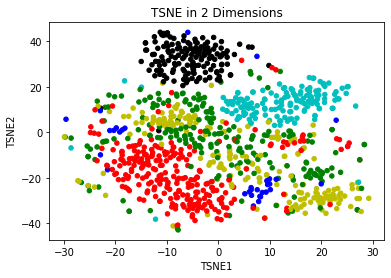

In [ ]:
df_airline.plot.scatter(title='TSNE in 2 Dimensions', x='TSNE1', y='TSNE2', c='color')

In [ ]:
#@title Run this cell to check your answer!

check_answer(embeddings.shape == (1000, 384))

## Correct! 🎉

Great! If done correctly, you'll notice that there is a relatively clear separation between the airlines.

However, this is probably mostly due to the fact that the airline names are present in the text through the hashtag.

Let's see what the embeddings represent when we scrub out the airline name from the tweet.

In the cell below, populate ```df['text_scrubbed']``` with a version of ```df['text']``` that does not contain the name of the airline from ```df['airline']```.

A few hints:
1. Using ```df.apply(lambda x: DO SOMETHING WITH x)``` is a good way to run operations on each row.
2. In Python, ```.replace('STRING', '')``` is a good way to remove a substring from a string.

Then, run the same analysis to see if there are any patterns.

In [ ]:
airlines = df_airline['airline'].unique()
def filter_airlines(s):
  for airline in airlines:
    s = s.replace('@'+airline, "")
  return s
# TODO: Remove the name of the airline from text

df_airline['text_scrubbed'] = df_airline['text'].apply(lambda s: " ".join(s.split()[1:]))

In [ ]:
df_airline.text_scrubbed.head(10)

0      877 from amsterdam to ewr, 02.27.2015, 737-300.
1    I'm on the 10:55 flight! Everyone has been so ...
2    we have posted your response on facebook for e...
3    a big thanks to the gate agent flt5127..keepin...
4    Do y'all know when the new routes from HOU to ...
5    502 M-phx Im still on The plane waiting And wa...
6    I bougth ticket same fligths twice and you don...
7    and no offers to provide us with a hotel or an...
8    how do you refuse a customer who is willing to...
9    plz help me win my bid upgrade for my flight 2...
Name: text_scrubbed, dtype: object

In [ ]:
# TODO: Plot the embeddings again!
embeddings = model.encode(df_airline['text_scrubbed'])

# TODO: Run TSNE on the embeddings
emb_tsne = TSNE(random_state=0, n_components=2, metric = 'cosine')
tsne_output = emb_tsne.fit_transform(embeddings)
# TODO: Scatter plot the TSNE embeddings, color-coding each point by the airline
df_airline['TSNE1'] = tsne_output[:, 0]
df_airline['TSNE2'] = tsne_output[:, 1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


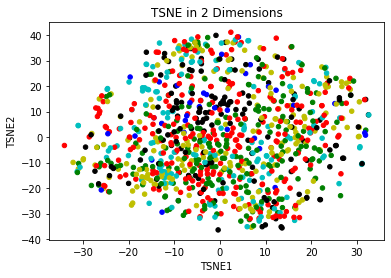

In [ ]:
df_airline.plot.scatter(title='TSNE in 2 Dimensions', x='TSNE1', y='TSNE2', c='color')

Are there still patterns found in the plots?

Here are some suggestions to look into:

1. Find extreme ends of the clusters and look at a small handlful (3-5) tweets in each cluster to see if there is any pattern.

2. See if there are other words in the tweets that you might be able to remove if there are spurious correlations!

#2. Using LLMs for downstream tasks

In this part of the assignment, we will explore how to load and use Large Language Models.

Thankfully, this has been made very easy with deep learning libraries like Huggingface.

In this section, we will just give a brief introduction to LLMs. However, if you are interested in learning more, please look into co:rise's NLP course!

Huggingface is a Python library that abstracts away many of the mind-numbing parts of deploying and running Large Language Models (in addition to vision, audio, and other tasks!).

To see this for yourself, run the following three lines:

In [ ]:
# Nothing to do here, just run!
from transformers import pipeline

model = pipeline("sentiment-analysis")
outputs = model("Deep learning is so much fun!")
print(outputs)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9998774528503418}]


Congrats! You've deployed a large language model!

*That's it?*

Let's break down what's going on here to give some more context.

The ```pipeline``` wrapper object and the highest level of abstraction in Huggingface. The first parameter is ```task```, which accepts a variety of tasks such as 'image-classification', 'question-answering', and 'text-generation'. You can see the full list of tasks [here](https://huggingface.co/docs/transformers/v4.19.2/en/main_classes/pipelines#transformers.pipeline.task)!

The second parameter (which is hidden in the code above) is ```model```. This allows you to specify the model that is used to run the task. As you might notice from the output of the cell above, the default model is *distilbert-base-uncased-finetuned-sst-2-english*. You can either provide the name of the model in the form of a string, or actually pass in a ```PreTrainedModel``` object.

Here is a list of possible models you can choose from:

[Huggingface Text Classification Models](https://huggingface.co/models?pipeline_tag=text-classification&sort=downloads)

In general, the default model is pretty good, so we can stick with that for now.

Now, let's see this in action. We're going to deploy a Gradio demo for sentiment analysis.

To demo how this works, just run the cell below:

In [ ]:
def sentiment_analysis(sentence):

  outputs = model(sentence)[0]

  score_dict = {outputs['label']: outputs['score']}

  return score_dict

interface = gr.Interface(fn=sentiment_analysis, inputs='text', outputs='label').launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

Using Embedded Colab Mode (NEW). If you have issues, please use share=True and file an issue at https://github.com/gradio-app/gradio/
Note: opening the browser inspector may crash Embedded Colab Mode.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


Ok, so you know how to load an NLP model from Huggingface. What if you wanted to use this for something at work? A common task is to figure out sentiment of users. You might have a lot of feedback/responses to a survey, and it's not easy to process each one.

## Airline Sentiment Analysis

With the Airline tweets dataset, answer the following question: "How would you rank each airline by percent of tweets with positive sentiment?"

The first thing we want to do is extract the predicted sentiment of each review in the dataset. To the dataframe ```df```, add a new column 'sentiment' that includes the model's predicted label, with 1 indicating a positive tweet and 0 indicating a negative tweet.

In [ ]:
# TODO: Gather model predictions. It should take around a minute to run this!
all_outputs = model(df_airline['text'].to_list())

# TODO: Set df['sentiment'] as a list of 1's and 0's, with 1='POSITIVE' and 0='NEGATIVE'
df_airline['sentiment'] = list(map(lambda x: 1 if x['label'] == 'POSITIVE' else 0, all_outputs))

In the cell below, populate the variable ```airline_rankings``` with a list of the six airlines, sorted by percent of positive sentiment tweets from highest to lowest.

For example, the list could look something like this: ```['Delta', 'US Airways', 'Virgin America', 'United', 'Southwest','American']```.

In [ ]:
# TODO: Compute the % of each airline's tweets that are positive!
# Note: There are a few ways to do this in Pandas -- you shouldn't hesitate to Google!
perc_airlines = df_airline.groupby('airline')['sentiment'].sum() / df_airline.groupby('airline')['sentiment'].count()
print(perc_airlines)
print(perc_airlines.sort_values(ascending=False).keys().to_list())


airline_rankings = perc_airlines.sort_values(ascending=False).keys().to_list()

airline
American          0.215789
Delta             0.337662
Southwest         0.357143
US Airways        0.186047
United            0.263780
Virgin America    0.212121
Name: sentiment, dtype: float64
['Southwest', 'Delta', 'United', 'American', 'Virgin America', 'US Airways']


In [ ]:
#@title Run this cell to check your answer!

check_answer(airline_rankings == ['Southwest', 'Delta', 'United', 'American', 'Virgin America', 'US Airways'])

## Correct! 🎉

Congrats! You've successfully used a large language model to rank airlines! If any of y'all are working at an airline, we really hope it's one at the top of this list! :) (Also, do these rankings roughly line up with what your experiences are?)

## Amazon Book Rating Prediction

For this next task, we'll be looking at book reviews from Amazon.

In particular, we're going to see how well we can predict the rating score (out of 5) based off the text alone.

Run the cell below to get an example of the data:



In [ ]:
# Just run this cell!
df_reviews = pd.read_csv(os.path.join(directory, 'utils/data/amazon-book-reviews', 'Books_rating.csv'), nrows=5000)
df_reviews.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


The reviews are found in the column ```review/text```, which contain a string.

Let's say your team finds that for a large number of reviews, the actual review score (x/5) is missing! Your job is to train a model that can predict the review score using only the text from the review.

For this part, we can simply this task to a binary classification problem: Predict whether a review has a high review (ie. 4 or 5 out of 5) or a low review (1-3 out of 5).

This can be done in the following steps:

1. Convert the reviews to a list of strings and extract embeddings from the ```SentenceTransformer``` model.
2. Convert the review score into a binary variable (1 for high review, and 0 for a low review).
3. Split your data (embeddings, labels) into training and test sets
4. Train a classification model (Logistic Regression) to predict whether a review is high or low scored.
5. Validate this model on testing data and report the ROC-AUC score.

The cells below outline these steps:

1. Convert the reviews to embeddings

In [ ]:
# TODO: Convert the "review/text" column into a list of strings and extract embeddings
reviews_list = df_reviews['review/text'].to_list()
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')
embeddings = model.encode(reviews_list)

In [ ]:
#@title Run this cell to check your answer!

check_answer(embeddings.shape==(5000, 384))

## Correct! 🎉

2. Create the response column

In [ ]:
# TODO: Create a column called 'high_review'
# Review of 1-3-> 0
# Review of 4-5-> 1

df_reviews['high_review'] = df_reviews['review/score'].apply(lambda score: 1 if int(score) >= 4 else 0).to_list()

In [ ]:
#@title Run this cell to check your answer!

check_answer(df_reviews['high_review'].mean() == 0.782)

## Correct! 🎉

3. Split your data into training and test sets

In [ ]:
# TODO: Using the function train_test_split, populate the variables below:

X_train, X_test, y_train, y_test = train_test_split(embeddings, df_reviews['high_review'])

In [ ]:
#@title Run this cell to check your answer!

check_answer(X_train.shape==(3750, 384))

## Correct! 🎉

4. Train your model!

In [ ]:
# TODO: Import sklearn's LogisticRegression model
from sklearn.linear_model import LogisticRegression

# TODO: Fit the model on the training data
model = LogisticRegression().fit(X_train, y_train)

5. Evaluate your model

We will be using the ROC-AUC score:
Just run the cell below!

In [ ]:
# Just run this cell

from sklearn.metrics import roc_auc_score

print(f'Your performance: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]): .3f} AUC')

Your performance:  0.829 AUC


Great job! If you did this right, you should be right around 0.85 AUC!

Can you cross the 0.90 AUC threshold by changing out the model or how the text data is cleaned?

# Summary

Thanks for making it all the way to the end of the last assignment!!

You might be thinking "hmm... this felt more like a data science project than a deep learning project". And you would be right!

So much of deep learning is abstracted away these days, the real expertise lies with those who know how to integrate DL models into the right applications.

We hope the tools and insights you have gleaned from this course will serve as a starting point for future exploration, and give you the confidence to reason through various exciting applications!

Best wishes,

Kevin and Eric